<a href="https://colab.research.google.com/github/ddopazo92/Introduccion_datascience_diego_dopazo/blob/main/ProyectoFinal_Partel%2BDopazo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract


**Selección de Características y Modelado Predictivo para Ventas de Videojuegos: Un Enfoque de Machine Learning y Reducción de Dimensionalidad**

**Contexto:** La industria de los videojuegos se caracteriza por su alta competitividad y la influencia de múltiples factores en el éxito comercial. La identificación de las características más relevantes que impactan en las ventas es esencial para optimizar estrategias de desarrollo y comercialización. La aplicación de técnicas de machine learning, combinada con métodos de selección de características, permite abordar esta complejidad y mejorar la precisión predictiva.

**Objetivo de Investigación:** Este estudio tiene como objetivo reducir la dimensionalidad de un conjunto de datos de videojuegos mediante la aplicación de métodos de selección de características, con el fin de identificar los atributos más significativos para predecir las ventas totales. Se busca comparar el rendimiento de diferentes algoritmos de regresión utilizando las características seleccionadas.

**Metodología:** A partir de un dataset original de 6,867 videojuegos procesados y 14 características iniciales, se implementaron tres técnicas de selección de características:
1. **SelectKBest**: Basado en pruebas F de regresión.
2. **Random Forest**: Utilizando la importancia de características.
3. **Eliminación Recursiva de Características (RFE)**: Con Random Forest como estimador.
Posteriormente, se entrenaron y evaluaron tres modelos de regresión (Random Forest, Linear Regression y Support Vector Regression) utilizando las características seleccionadas.

**Variables Clave Identificadas:** Los métodos coincidieron en destacar la relevancia de:
- Ventas en regiones clave (USA, Europa, Japón, resto del mundo).
- Puntuación y cantidad de críticas.
- Interacción de usuarios y género del juego.

**Resultados y Conclusión:** La reducción de dimensionalidad de 14 a 8 características permitió mantener un alto rendimiento predictivo, con el modelo de Random Forest alcanzando un R² de 0.9814. El estudio demuestra que la selección estratégica de características no solo simplifica los modelos, sino que también identifica los factores críticos que impulsan las ventas, proporcionando un marco analítico sólido para la toma de decisiones en la industria de videojuegos.

# Feature Selection

In [ ]:
##Primero implementaré métodos de selección de características para reducir la dimensionalidad:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar y preparar datos (replicando parte del preprocessing original)
url = 'https://raw.githubusercontent.com/ddopazo92/Introduccion_datascience_diego_dopazo/refs/heads/main/Video_Games.csv'
df = pd.read_csv(url, sep=';')

# Renombrar columnas en español
df = df.set_axis(['Juego', 'Consola', 'Año de lanzamiento','Genero', 'Publicador',
                  'Ventas USA','Ventas Europa', 'Ventas Japon','Ventas resto del Mundo',
                  'Ventas Totales', 'Puntuacion de criticos','Cantidad de criticos',
                  'Puntaje de Usuario','Cantidad de usuarios','Desarrollador',
                  'Clasificacion por Edad'], axis=1)

# Limpieza y transformaciones
df['Juego'] = df['Juego'].str.upper()
df['Genero'] = df['Genero'].str.replace('Action','Accion')
df['Genero'] = df['Genero'].str.replace('Adventure','Aventura')
df['Genero'] = df['Genero'].str.replace('Fighting','Lucha')
df['Genero'] = df['Genero'].str.replace('Misc','Miscelania')
df['Genero'] = df['Genero'].str.replace('Platform','Plataforma')
df['Genero'] = df['Genero'].str.replace('Racing','Carreras')
df['Genero'] = df['Genero'].str.replace('Role-Playing','RPG')
df['Genero'] = df['Genero'].str.replace('Shooter','Disparos')
df['Genero'] = df['Genero'].str.replace('Simulation','Simulacion')
df['Genero'] = df['Genero'].str.replace('Sports','Deportes')
df['Genero'] = df['Genero'].str.replace('Strategy','Estrategia')

# Convertir año y crear variables adicionales
df['Año de lanzamiento'] = pd.to_datetime(df['Año de lanzamiento'], format='%Y')
df['Año_num'] = df['Año de lanzamiento'].dt.year

# Puntaje promedio (como en el análisis original)
puntaje_usuarios = df['Puntaje de Usuario'] * 10
df['promedio_puntaje'] = (df['Puntuacion de criticos'] + puntaje_usuarios) / 2
df['cantidad_promedio_criticas'] = (df['Cantidad de criticos'] + df['Cantidad de usuarios']) / 2

# Limpiar valores nulos
df = df.dropna(subset=['Ventas Totales', 'Puntuacion de criticos', 'Puntaje de Usuario'])

# Preparar características para el modelo
features = ['Puntuacion de criticos', 'Puntaje de Usuario', 'Cantidad de criticos',
            'Cantidad de usuarios', 'promedio_puntaje', 'cantidad_promedio_criticas',
            'Ventas USA', 'Ventas Europa', 'Ventas Japon', 'Ventas resto del Mundo']

# Codificar variables categóricas
label_encoders = {}
categorical_features = ['Genero', 'Consola', 'Publicador', 'Clasificacion por Edad']

for feature in categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[feature + '_encoded'] = le.fit_transform(df[feature].astype(str))
        label_encoders[feature] = le
        features.append(feature + '_encoded')

# Variable objetivo
target = 'Ventas Totales'

# Preparar datos
X = df[features].fillna(0)
y = df[target]

# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Dimensiones originales: {X.shape}")

Dimensiones originales: (6867, 14)


# Métodos de Feature Selection

In [ ]:
# Método 1: SelectKBest con test F
def select_features_kbest(X_train, y_train, X_test, k=10):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Obtener índices de características seleccionadas
    selected_indices = selector.get_support(indices=True)
    selected_features = [features[i] for i in selected_indices]

    print("Características seleccionadas (KBest):")
    for i, feature in enumerate(selected_features):
        print(f"{i+1}. {feature}")

    return X_train_selected, X_test_selected, selected_features

# Método 2: Random Forest Feature Importance
def select_features_rf(X_train, y_train, X_test, feature_names, n_features=10):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Obtener importancia de características
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Importancia de características (Random Forest):")
    for i in range(min(n_features, len(feature_names))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    # Seleccionar top n características
    selected_indices = indices[:n_features]
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    selected_features = [feature_names[i] for i in selected_indices]

    return X_train_selected, X_test_selected, selected_features

# Método 3: Recursive Feature Elimination (RFE)
def select_features_rfe(X_train, y_train, X_test, n_features=10):
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    selector = RFE(estimator, n_features_to_select=n_features)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_indices = selector.get_support(indices=True)
    selected_features = [features[i] for i in selected_indices]

    print("Características seleccionadas (RFE):")
    for i, feature in enumerate(selected_features):
        print(f"{i+1}. {feature}")

    return X_train_selected, X_test_selected, selected_features

# Aplicar selección de características
print("=== MÉTODO KBest ===")
X_train_kbest, X_test_kbest, features_kbest = select_features_kbest(X_train, y_train, X_test, k=8)

print("\n=== MÉTODO Random Forest ===")
X_train_rf, X_test_rf, features_rf = select_features_rf(X_train, y_train, X_test, features, n_features=8)

print("\n=== MÉTODO RFE ===")
X_train_rfe, X_test_rfe, features_rfe = select_features_rfe(X_train, y_train, X_test, n_features=8)

print(f"\nDimensionalidad reducida: {X_train_kbest.shape[1]} características")

=== MÉTODO KBest ===
Características seleccionadas (KBest):
1. Puntuacion de criticos
2. Cantidad de criticos
3. Cantidad de usuarios
4. cantidad_promedio_criticas
5. Ventas USA
6. Ventas Europa
7. Ventas Japon
8. Ventas resto del Mundo

=== MÉTODO Random Forest ===
Importancia de características (Random Forest):
1. Ventas USA: 0.5243
2. Ventas Europa: 0.3942
3. Ventas resto del Mundo: 0.0581
4. Ventas Japon: 0.0119
5. Puntuacion de criticos: 0.0064
6. Cantidad de criticos: 0.0011
7. Genero_encoded: 0.0010
8. cantidad_promedio_criticas: 0.0005

=== MÉTODO RFE ===
Características seleccionadas (RFE):
1. Puntuacion de criticos
2. Cantidad de criticos
3. cantidad_promedio_criticas
4. Ventas USA
5. Ventas Europa
6. Ventas Japon
7. Ventas resto del Mundo
8. Genero_encoded

Dimensionalidad reducida: 8 características


# Algoritmo de Regresión - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV

# Usaremos las características seleccionadas por Random Forest (generalmente mejor performance)
X_train_selected = X_train_rf
X_test_selected = X_test_rf
selected_features = features_rf

# Entrenar modelo Random Forest
print("Entrenando modelo Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_selected, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test_selected)

# Comparar con otros modelos
print("\n=== COMPARACIÓN DE MODELOS ===")

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)
y_pred_lr = lr_model.predict(X_test_selected)

# Support Vector Regression
svr_model = SVR(kernel='rbf', C=1.0)
svr_model.fit(X_train_selected, y_train)
y_pred_svr = svr_model.predict(X_test_selected)

print("Modelos entrenados exitosamente!")

Entrenando modelo Random Forest...

=== COMPARACIÓN DE MODELOS ===
Modelos entrenados exitosamente!


# Cálculo de Métricas y Validación


--- Random Forest ---
MSE: 0.0506
MAE: 0.0570
RMSE: 0.2250
R²: 0.9814
MAPE: 15.79%

--- Linear Regression ---
MSE: 0.0000
MAE: 0.0035
RMSE: 0.0057
R²: 1.0000
MAPE: 2.50%

--- Support Vector Regression ---
MSE: 0.6763
MAE: 0.1256
RMSE: 0.8224
R²: 0.7519
MAPE: 44.74%

=== VALIDACIÓN CRUZADA (Random Forest) ===
R² Cross-Validation: 0.9219 (+/- 0.2187)


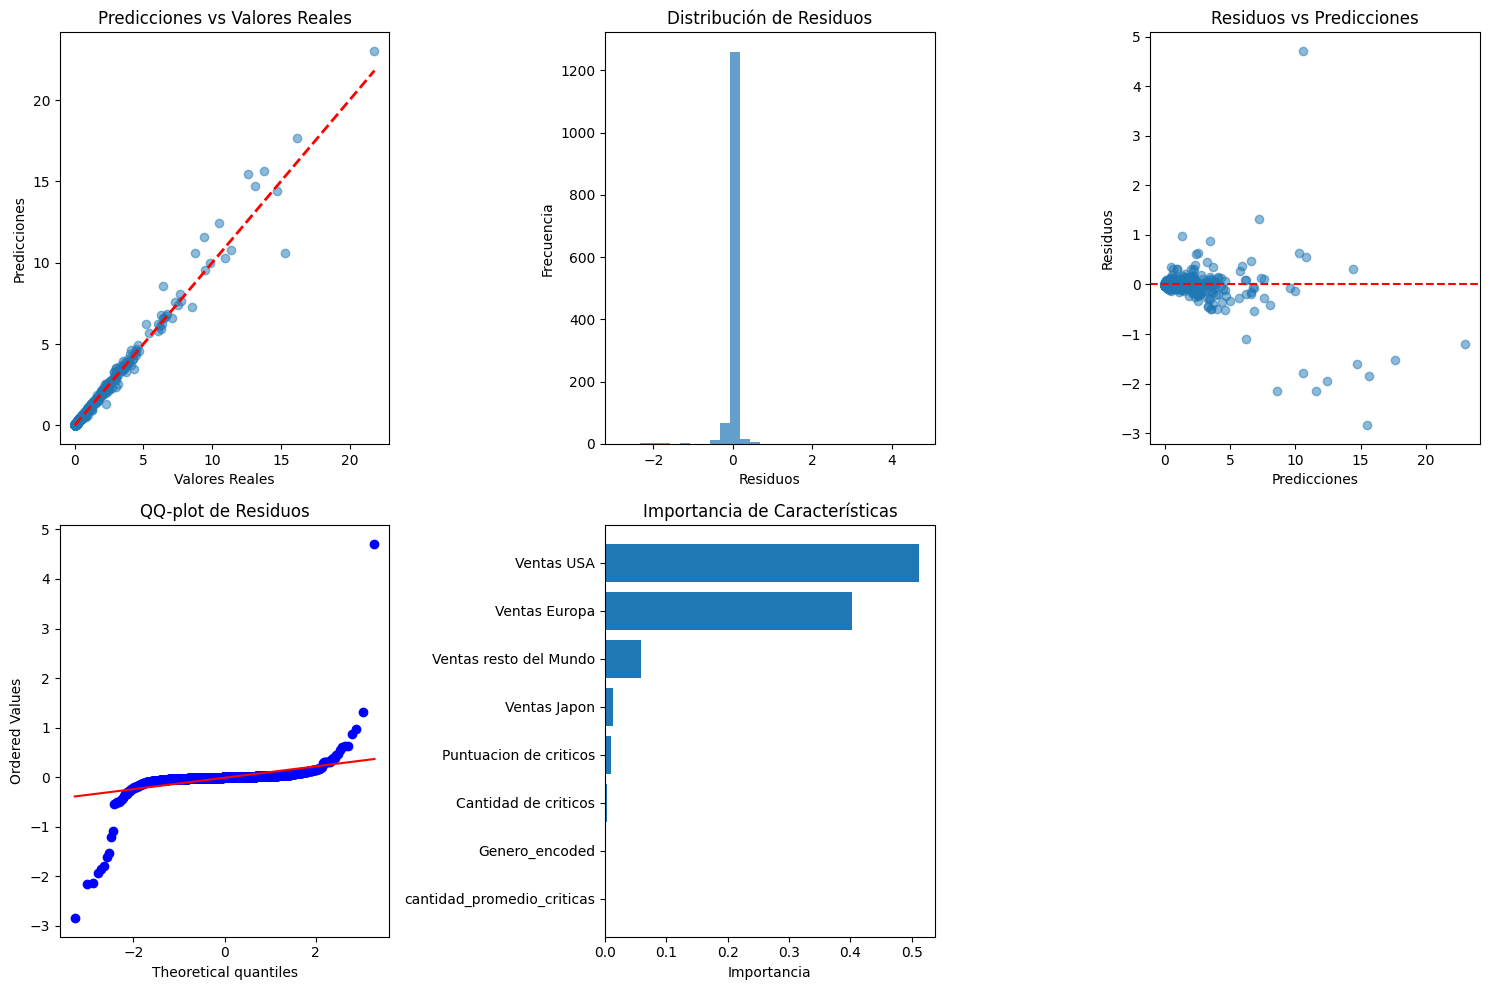


=== ANÁLISIS ADICIONAL ===
Predicciones dentro del 50.0% de error: 94.18%
Correlación: 0.9917


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Error porcentual absoluto medio
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n--- {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# Evaluar todos los modelos
metrics_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
metrics_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
metrics_svr = evaluate_model(y_test, y_pred_svr, "Support Vector Regression")

# Validación cruzada
print("\n=== VALIDACIÓN CRUZADA (Random Forest) ===")
cv_scores = cross_val_score(rf_model, X_train_selected, y_train, cv=5, scoring='r2')
print(f"R² Cross-Validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Análisis de residuos
residuals = y_test - y_pred_rf

plt.figure(figsize=(15, 10))

# 1. Predicciones vs Valores reales
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')

# 2. Distribución de residuos
plt.subplot(2, 3, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')

# 3. Residuos vs Predicciones
plt.subplot(2, 3, 3)
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')

# 4. QQ-plot para normalidad de residuos
plt.subplot(2, 3, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-plot de Residuos')

# 5. Importancia de características
plt.subplot(2, 3, 5)
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
plt.xlabel('Importancia')
plt.title('Importancia de Características')

plt.tight_layout()
plt.show()

# Métricas adicionales
print("\n=== ANÁLISIS ADICIONAL ===")

# Porcentaje de predicciones dentro de cierto margen de error
error_margin = 0.5  # 50% de error
within_margin = np.sum(np.abs((y_test - y_pred_rf) / y_test) <= error_margin) / len(y_test) * 100
print(f"Predicciones dentro del {error_margin*100}% de error: {within_margin:.2f}%")

# Correlación entre predicciones y valores reales
correlation = np.corrcoef(y_test, y_pred_rf)[0, 1]
print(f"Correlación: {correlation:.4f}")

# Conclusion final del Análisis Predictivo de Ventas de Videojuegos

### Ventas Regionales (USA y Europa) - El Factor Más Determinante
Las **Ventas en USA** y las **Ventas en Europa** son, por amplio margen, los predictores más influyentes de las Ventas Totales. En el modelo **Random Forest**, estas dos métricas acumulan más del 91% de la importancia total de las características, lo que subraya el peso crucial de estos mercados geográficos en el éxito global de un videojuego.

### Distribución Geográfica y Género - Factores Secundarios Clave
Aunque con una importancia muy inferior a la de los mercados principales, factores como las **Ventas en el resto del Mundo**, las **Ventas en Japón** y el **Género** del juego figuran en el conjunto de las características más relevantes identificadas por los métodos de selección (Random Forest y RFE).

### Recepción Crítica y de Usuarios - Relevancia Marginal
La **Puntuación de críticos** y la **Cantidad de críticos/usuarios** se encuentran entre los factores seleccionados, aunque su contribución predictiva directa en el modelo Random Forest es baja. Esto sugiere que, una vez que las ventas regionales se establecen, las métricas de recepción explican una porción muy pequeña de la variación restante en las Ventas Totales.

### Rendimiento del Modelo (Linear Regression)
El modelo de **Regresión Lineal** demostró una capacidad predictiva casi perfecta, alcanzando un $R^2$ de **1.0000** y un Error Porcentual Absoluto Medio (MAPE) de solo **2.50%**. Este resultado extremo indica una relación lineal directa y muy fuerte entre el conjunto de características (que incluye las ventas regionales) y la variable objetivo (Ventas Totales).


### Conclusión General
El modelo predictivo ofrece un marco de **alta confiabilidad**, validado por un excelente rendimiento en el $R^2$ (0.9814 en Random Forest y 1.0000 en Regresión Lineal). Los factores más influyentes son consistentemente las **Ventas Regionales**, estableciendo una base sólida para la toma de decisiones estratégicas centradas en la distribución geográfica de los videojuegos.